In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.stats"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr

from util import subject
from scipy.stats import zscore
from himalaya.scoring import correlation_score, correlation_score_split

from util import plot, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

from matplotlib.colors import LinearSegmentedColormap, ListedColormap


# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
FG_MASK = get_brainmask()

In [4]:
modelname = "joint_nosplit"
cache = 'default_task'

In [5]:
cachedir = f'results/cache/figureX-black-compare/{modelname}/'
resultdir = f'figures/figure2/black-compare/{modelname}/'
!mkdir -p $resultdir
!mkdir -p $cachedir

resultdir

'figures/figure2/black-compare/joint_nosplit/'

# within-subject encoding performances on conversation data

In [52]:
model_results = {}

suffix = '_n2'
encmodel = f"encoding_{cache}{suffix}"

respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

suffix = '_exclusive'

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    if sub in [111, 11, 12]: continue
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        results[f'cv_scores_prod'].append(f['cv_scores_prod_exclusive'][0, -1, :])
        results[f'cv_scores_comp'].append(f['cv_scores_comp_exclusive'][0, -1, :])
model_results['conv'] = results

# black story
encmodel = f"encoding_black_{cache}"

respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue

    with h5py.File(respath, "r") as f:
        results['cv_scores_comp'].append(f['cv_scores_comp_exclusive'][-1])
        results['cv_scores_prod'].append(f['cv_scores_prod_exclusive'][-1])

model_results['story'] = results
model_results.keys()

 55%|█████▌    | 32/58 [00:00<00:00, 156.61it/s]

skip results/encoding_black_default_task/sub-111/joint_nosplit/sub-111.hdf5
skip results/encoding_black_default_task/sub-011/joint_nosplit/sub-011.hdf5
skip results/encoding_black_default_task/sub-012/joint_nosplit/sub-012.hdf5


100%|██████████| 58/58 [00:00<00:00, 161.58it/s]


dict_keys(['conv', 'story'])

In [53]:
conv_comp_scores = np.stack(model_results['conv']['cv_scores_comp'])
conv_prod_scores = np.stack(model_results['conv']['cv_scores_prod'])

story_comp_scores = np.stack(model_results['story']['cv_scores_comp'])
story_prod_scores = np.stack(model_results['story']['cv_scores_prod'])

story_comp_scores.shape, conv_comp_scores.shape

((55, 81924), (55, 81924))

### plot conv-trained model performance

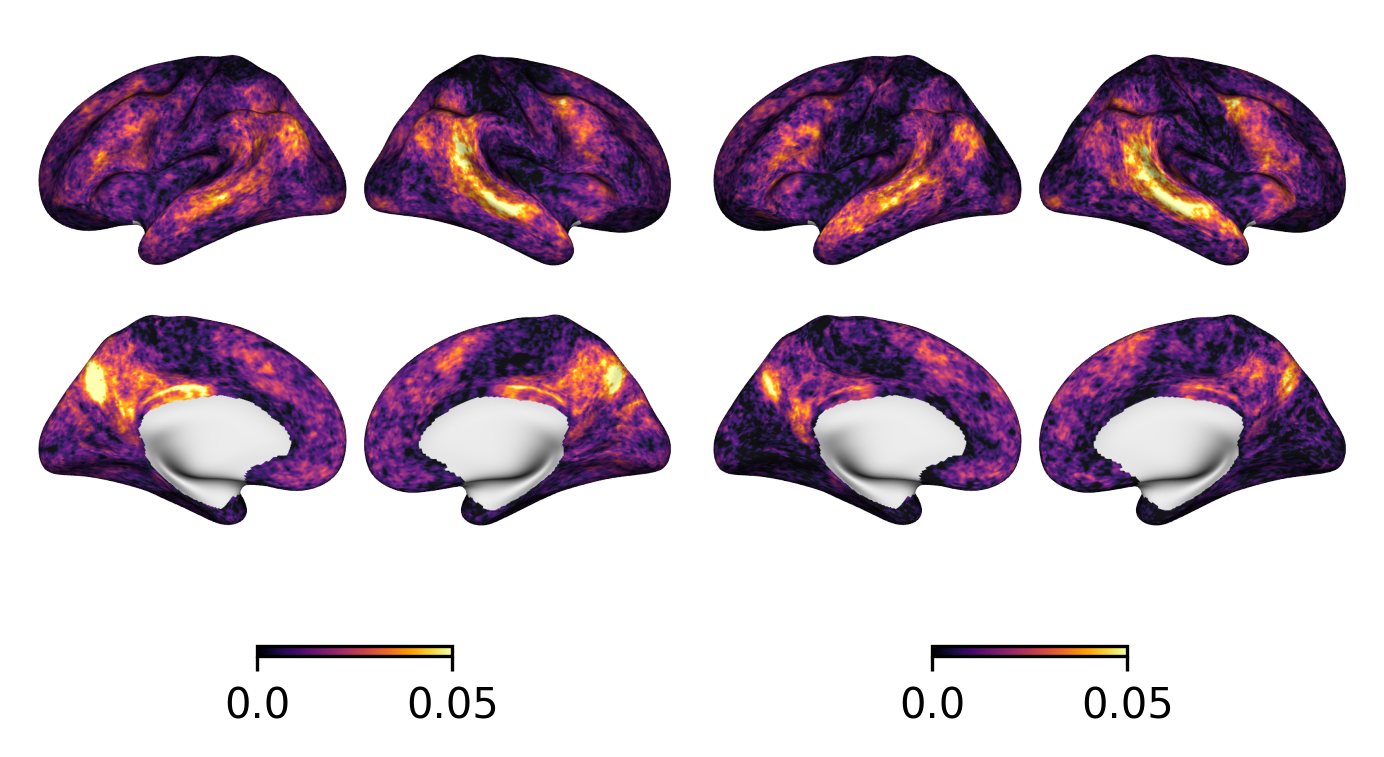

In [8]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(conv_prod_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(conv_comp_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

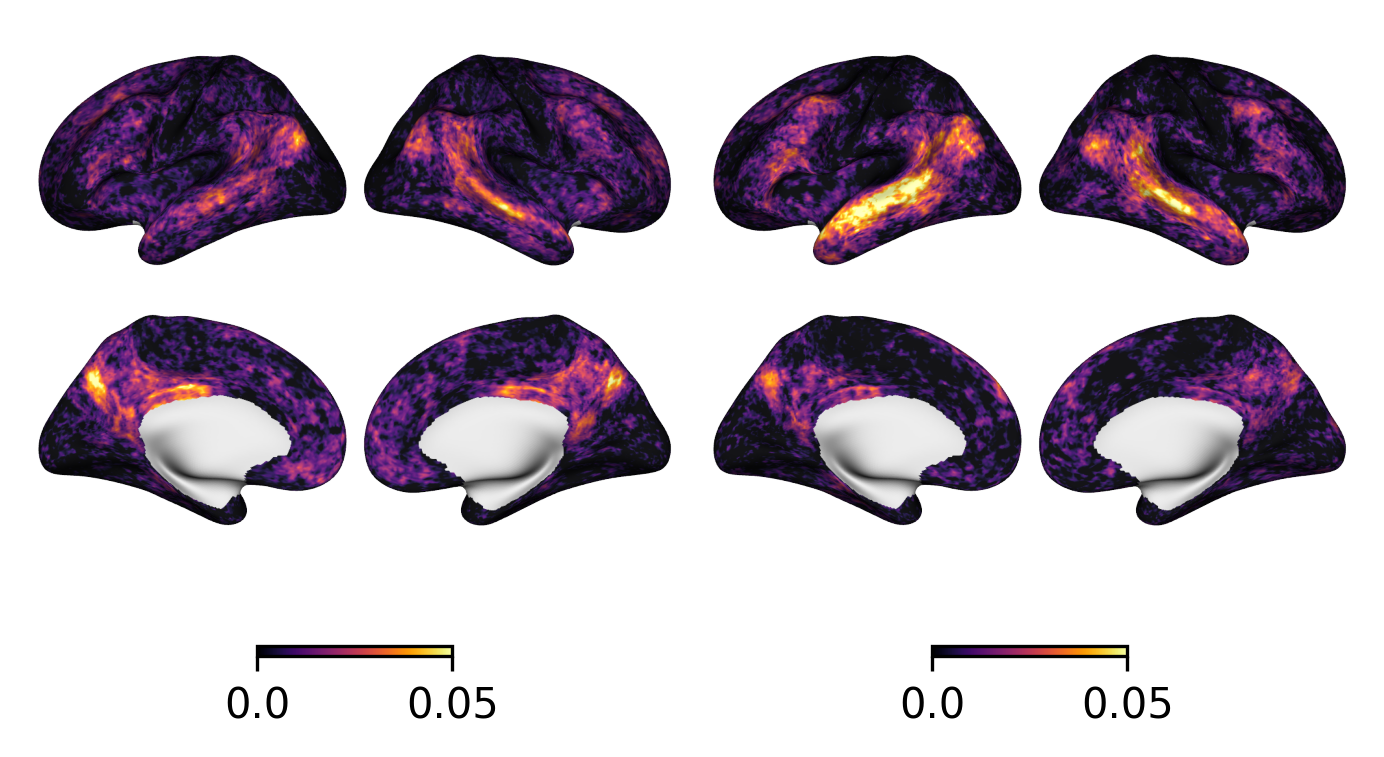

In [9]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(story_prod_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(story_comp_scores.mean(0), vmin=0, vmax=0.05, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

In [54]:
prod_p_values = stats.ttest_1samp(conv_prod_scores, correlations=True)
comp_p_values = stats.ttest_1samp(conv_comp_scores, correlations=True)
conv_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
conv_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

prod_p_values = stats.ttest_1samp(story_prod_scores, correlations=True)
comp_p_values = stats.ttest_1samp(story_comp_scores, correlations=True)
story_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
story_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

prod_sigmask = conv_prod_sigmask | story_prod_sigmask
comp_sigmask = conv_comp_sigmask | story_comp_sigmask

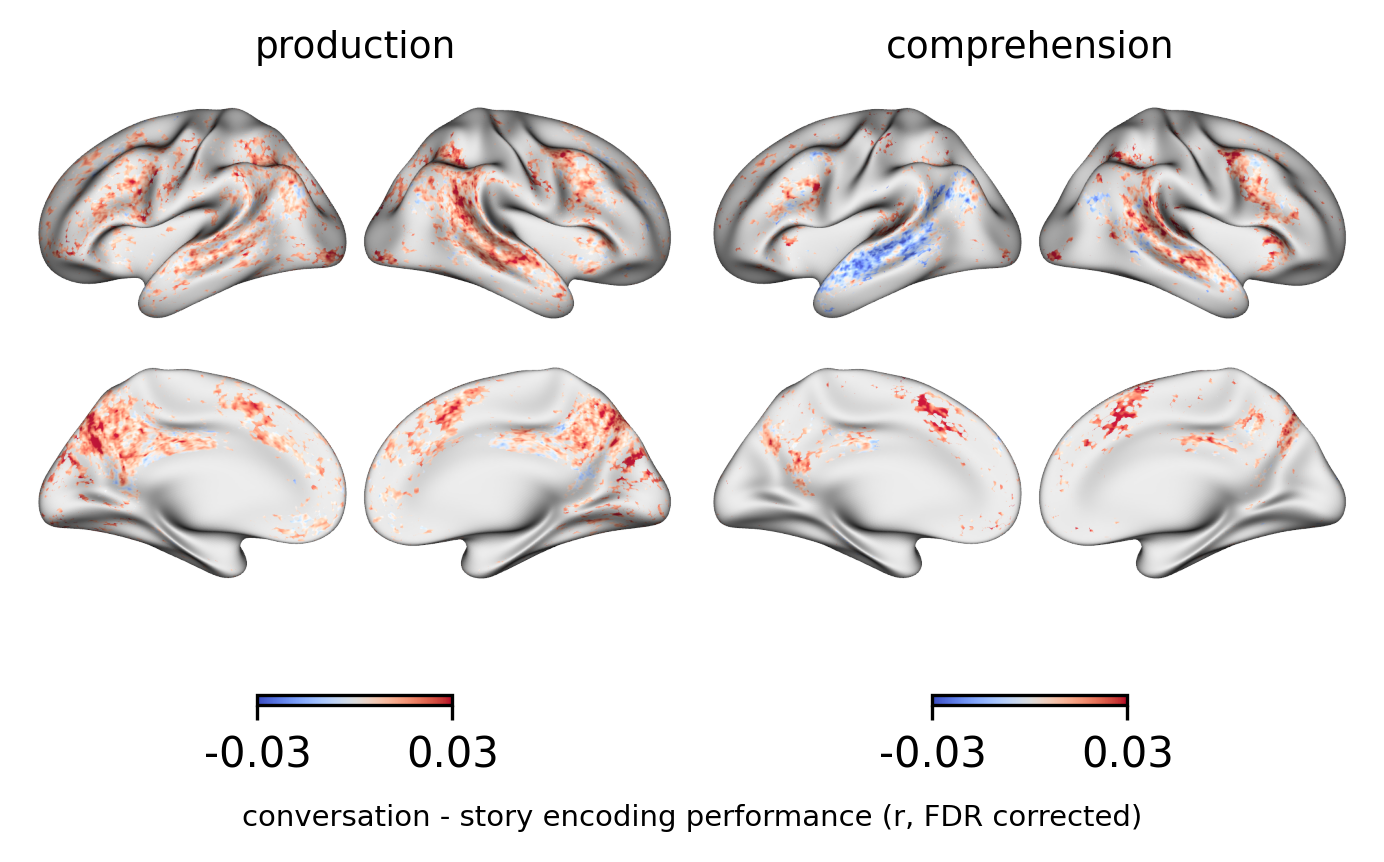

In [55]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot((conv_prod_scores - story_prod_scores).mean(0), fig=fig, ax=axes[0], threshold=~prod_sigmask)
plot.surface_plot((conv_comp_scores - story_comp_scores).mean(0), fig=fig, ax=axes[1], threshold=~comp_sigmask)
axes[0].set_title("production")
axes[1].set_title("comprehension")
fig.supxlabel("conversation - story encoding performance (r, FDR corrected)", fontsize=7)
fig.show()

### compute sig. difference

In [12]:
from scipy.stats import ttest_rel

In [ ]:
conv_prod_scores = conv_prod_scores[..., FG_MASK].mean(-1)
conv_comp_scores = conv_comp_scores[..., FG_MASK].mean(-1)

black_prod_scores = story_prod_scores[..., FG_MASK].mean(-1)
black_comp_scores = story_prod_scores[..., FG_MASK].mean(-1)

conv_comp_scores.shape, black_comp_scores.shape

((55,), (55,))

In [ ]:
print((conv_comp_scores.mean() - black_comp_scores.mean()) / conv_comp_scores.mean())
print((conv_prod_scores.mean() - black_prod_scores.mean()) / conv_prod_scores.mean())

0.4087569
0.4918481


In [ ]:
print('comp', ttest_rel(conv_comp_scores, black_comp_scores))
print('prod', ttest_rel(conv_prod_scores, black_prod_scores))

comp TtestResult(statistic=3.2280294448780915, pvalue=0.0021214168591717664, df=54)
prod TtestResult(statistic=5.0431023786383875, pvalue=5.501454361197233e-06, df=54)


### scatter plot diff

In [ ]:
conv_prod_scores = conv_prod_scores[..., FG_MASK].mean(0)
conv_comp_scores = conv_comp_scores[..., FG_MASK].mean(0)

black_prod_scores = story_prod_scores[..., FG_MASK].mean(0)
black_comp_scores = story_prod_scores[..., FG_MASK].mean(0)

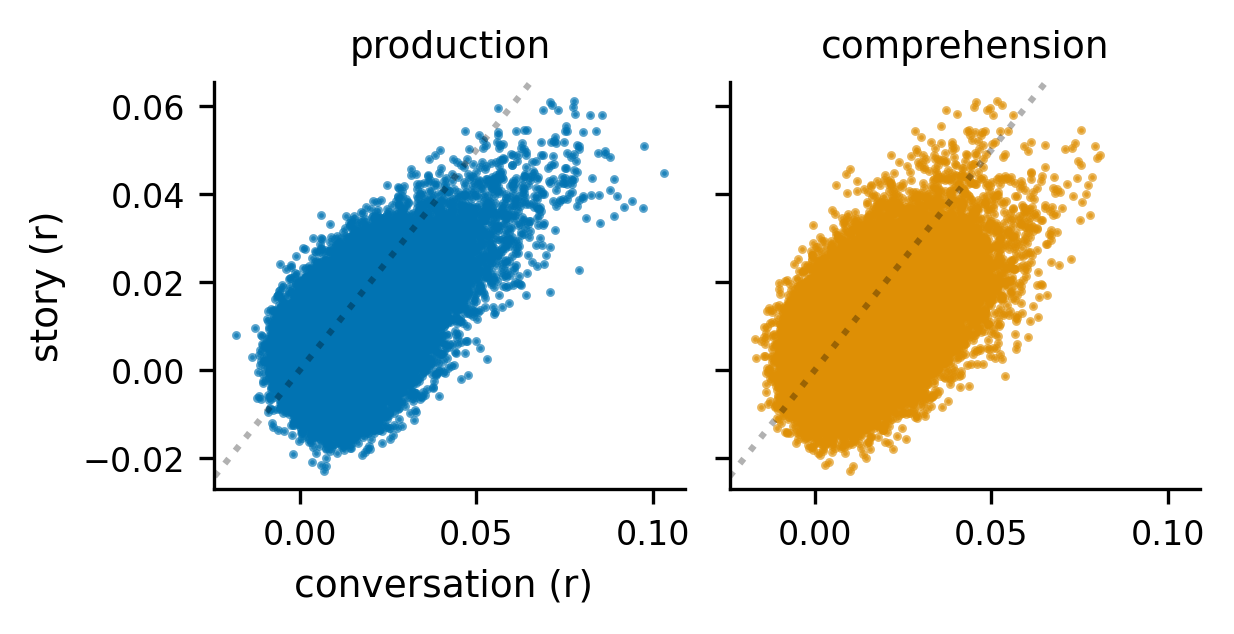

In [ ]:
fig, axes = plt.subplots(1, 2, layout='constrained', dpi=300, sharex=True, sharey=True, figsize=(4, 2))
axes[0].scatter(conv_prod_scores, black_prod_scores, marker='.', color=BLU, alpha=0.65, s=5)
axes[1].scatter(conv_comp_scores, black_comp_scores, marker='.', color=ORG, alpha=0.65, s=5)

axes[0].set_xlabel('conversation (r) ')
axes[0].set_ylabel('story (r)')

axes[0].set_title('production')
axes[1].set_title('comprehension')

axes[0].axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')
axes[1].axline(xy1=(0, 0), slope=1, alpha=0.3, c="k", ls='dotted')

fig.show()

# across-subject encoding performance in conversations

In [41]:
from encoding import SplitDelayer
delayer = SplitDelayer(delays=[0, 1, 2, 3, 4, 5])

In [42]:
model_results = {}

suffix = '_n2'

conv_respath = Path(
    root='results/' + f"encoding_{cache}{suffix}",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)
black_respath = Path(
    root='results/' + f"encoding_black_{cache}",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
# test subA's conv-predictions on subB's actual data from the two models

for subA in tqdm(SUBS_STRANGERS):
    if subA in [111, 11, 12]:
        continue

    subB = subject.get_partner(subA)

    conv_respath.update(sub=f"{subA:03d}")
    black_respath.update(sub=f"{subA:03d}")

    # these predictions are for subA's data
    with h5py.File(conv_respath, "r") as f:
        conv_preds = f['cv_preds'][0, ...] # (1, 5, 720, 81924)

    with h5py.File(black_respath, "r") as f:
        black_preds = f['cv_preds'][...] # (4, 720, 81924)

    subB_data = subject.get_bold(subB, cache)  # 1200 TRs
    subB_test = subB_data[480:]

    prod_boxcar, _, _ = subject.get_timinglog_boxcars(subB)
    prod_mask = prod_boxcar.astype(bool)
    comp_mask = ~ prod_mask
    prod_mask = delayer.fit_transform(prod_mask[..., None]).any(-1)
    comp_mask = delayer.fit_transform(comp_mask[..., None]).any(-1)
    prod_only_mask = prod_mask & ~comp_mask
    comp_only_mask = comp_mask & ~prod_mask
    prod_only_mask = prod_only_mask[480:]
    comp_only_mask = comp_only_mask[480:]

    conv_prod_scores = correlation_score_split(subB_test[prod_only_mask], conv_preds[:, prod_only_mask])
    conv_comp_scores = correlation_score_split(subB_test[comp_only_mask], conv_preds[:, comp_only_mask])
    black_prod_scores = correlation_score_split(subB_test[prod_only_mask], black_preds[:, prod_only_mask])
    black_comp_scores = correlation_score_split(subB_test[comp_only_mask], black_preds[:, comp_only_mask])

    # just take the LLM prediction scores
    results['conv_prod'].append(conv_prod_scores[-1])
    results['conv_comp'].append(conv_comp_scores[-1])
    results['black_prod'].append(black_prod_scores[-1])
    results['black_comp'].append(black_comp_scores[-1])

100%|██████████| 58/58 [06:58<00:00,  7.22s/it]


In [43]:
all_conv_prod_scores = np.stack(results['conv_prod'])
all_conv_comp_scores = np.stack(results['conv_comp'])
all_black_prod_scores = np.stack(results['black_prod'])
all_black_comp_scores = np.stack(results['black_comp'])

avg_conv_prod_scores = all_conv_prod_scores.mean(0)
avg_conv_comp_scores = all_conv_comp_scores.mean(0)
avg_black_prod_scores = all_black_prod_scores.mean(0)
avg_black_comp_scores = all_black_comp_scores.mean(0)

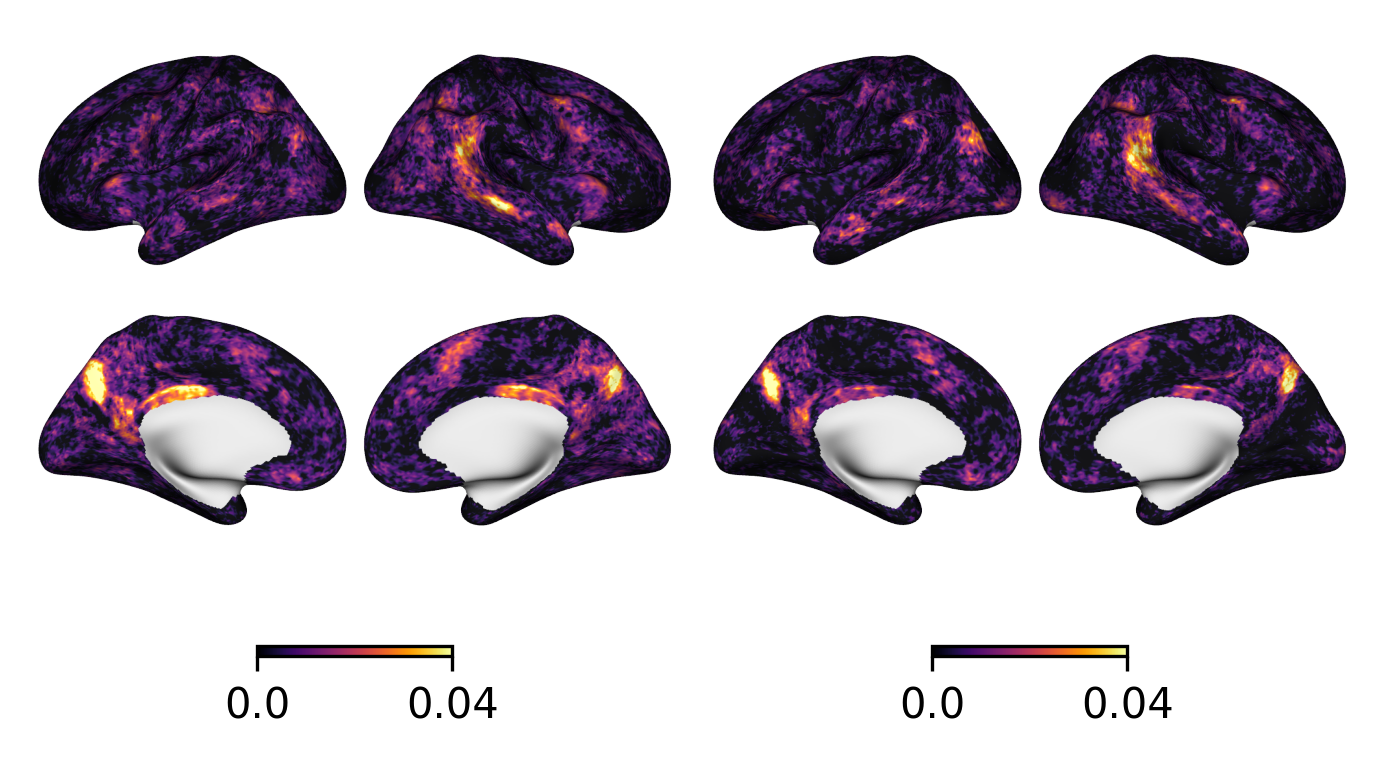

In [44]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(avg_conv_prod_scores, vmin=0, vmax=0.04, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(avg_conv_comp_scores, vmin=0, vmax=0.04, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

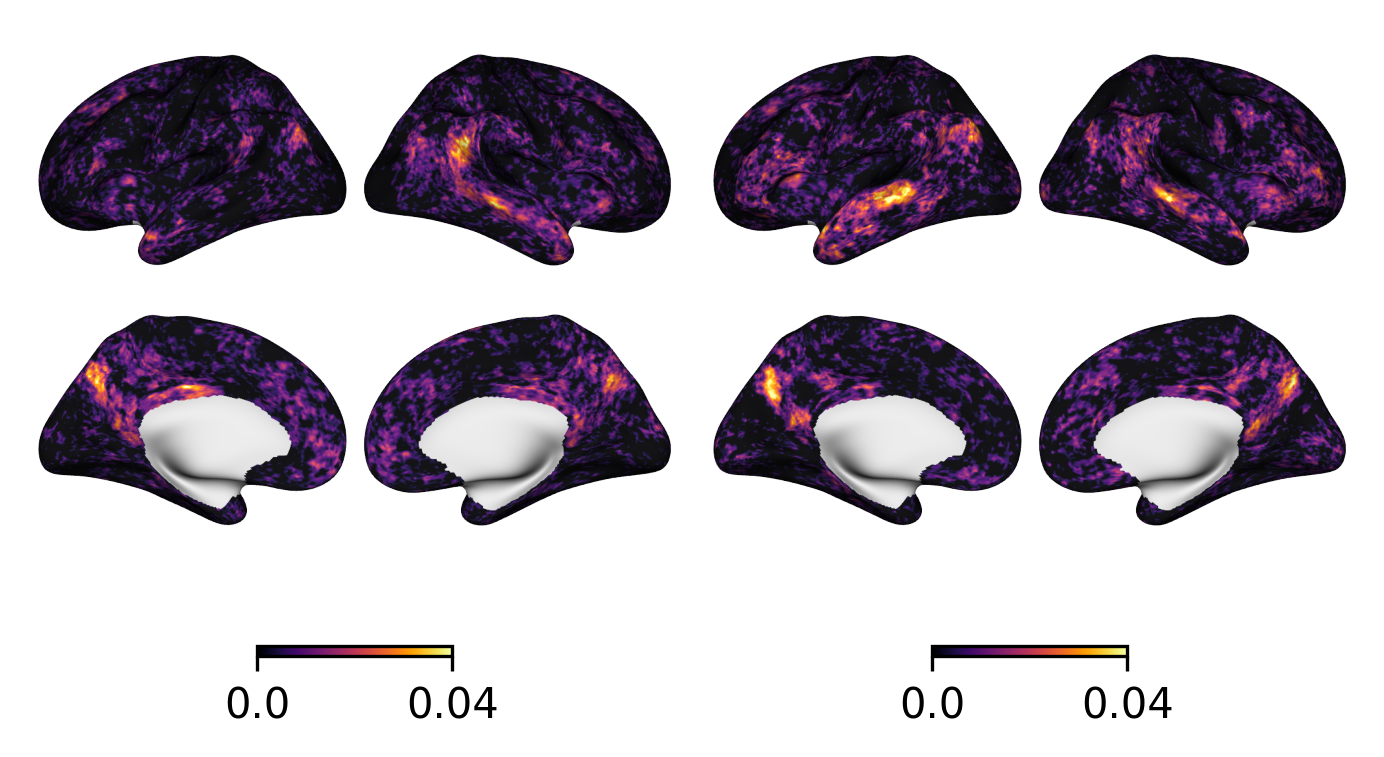

In [45]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot(avg_black_prod_scores, vmin=0, vmax=0.04, cmap='inferno', fig=fig, ax=axes[0])
plot.surface_plot(avg_black_comp_scores, vmin=0, vmax=0.04, cmap='inferno', fig=fig, ax=axes[1])
fig.show()

In [46]:
prod_p_values = stats.ttest_1samp(all_conv_prod_scores, correlations=True)
comp_p_values = stats.ttest_1samp(all_conv_comp_scores, correlations=True)
conv_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
conv_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

prod_p_values = stats.ttest_1samp(all_black_prod_scores, correlations=True)
comp_p_values = stats.ttest_1samp(all_black_comp_scores, correlations=True)
story_prod_sigmask = stats.correct_multiple_tests(prod_p_values, method='fdr_bh', alpha=0.05)
story_comp_sigmask = stats.correct_multiple_tests(comp_p_values, method='fdr_bh', alpha=0.05)

prod_sigmask = conv_prod_sigmask | story_prod_sigmask
comp_sigmask = conv_comp_sigmask | story_comp_sigmask

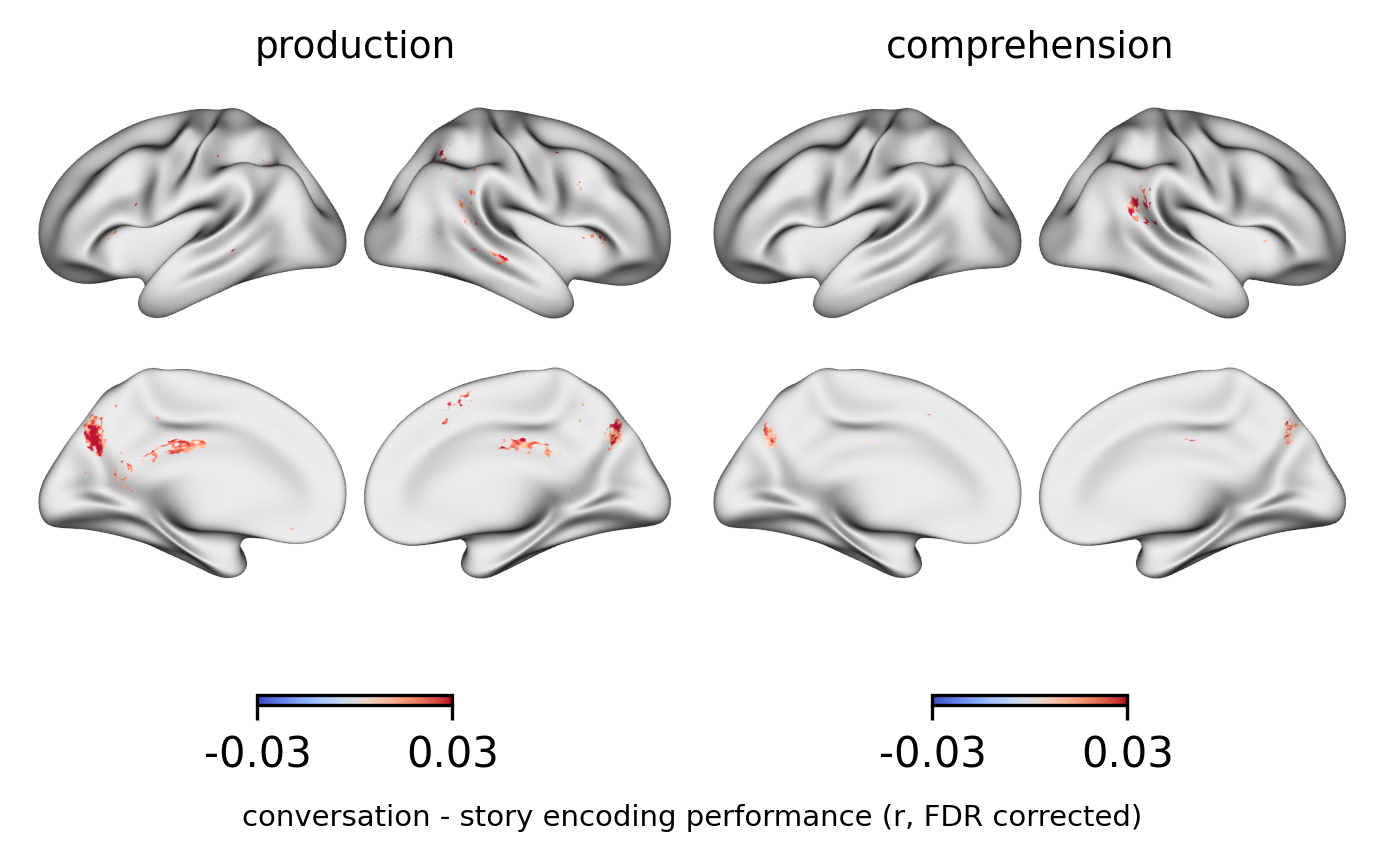

In [51]:
fig, axes = plot.two_brain_fig(layout="constrained", dpi=300)
plot.surface_plot((all_conv_prod_scores - all_black_prod_scores).mean(0), fig=fig, ax=axes[0], threshold=~prod_sigmask)
plot.surface_plot((all_conv_comp_scores - all_black_comp_scores).mean(0), fig=fig, ax=axes[1], threshold=~comp_sigmask)
axes[0].set_title("production")
axes[1].set_title("comprehension")
fig.supxlabel("conversation - story encoding performance (r, FDR corrected)", fontsize=7)
fig.show()

# within-subject black story encoding

In [ ]:
encmodel = "encoding_black"

modelname = 'model-gpt2-2b_layer-24'
features = ["stats", "acoustic", "articulatory", "LLM"]

modelname = 'contextual'
features = ["stats", "LLM"]

In [ ]:
respath = Path(
    root='results/' + encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        results['black_cv_scores'].append(f['black_cv_scores'][...])

In [ ]:
sub_black_scores = np.stack(results['black_cv_scores'])
avg_black_scores = sub_black_scores.mean((0, 1))
sub_black_scores.shape

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), dpi=300, layout='constrained')
for i, ax in enumerate(axes):
    plot.surface_plot(avg_black_scores[i], fig=fig, ax=ax, vmin=0, cmap='inferno', title=features[i])
fig.show()

In [ ]:
sub_llm_black_scores = sub_black_scores[:, :, -1].mean(1)
sub_llm_black_scores.shape 

In [ ]:
black_p_values = stats.ttest_1samp(sub_llm_black_scores, correlations=True)
black_sigmask = stats.correct_multiple_tests(black_p_values, method='fdr_bh', alpha=0.01)
black_sigmask.sum() 

In [ ]:
avg_llm_black_scores = sub_llm_black_scores.mean(0)
avg_llm_black_scores[black_sigmask].min(), avg_llm_black_scores.max()

In [ ]:
plot.surface_plot(avg_llm_black_scores, vmin=0, cmap='inferno', threshold=~black_sigmask);